# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option('display.max_columns', 250)

In [2]:
df = pd.read_csv('../data/clean_final.csv')

In [3]:
df.head()

,Id,CreationDate,Title,Body,Tags,ViewCount,AnswerCount,CommentCount,target_tags,overlap_tags,target_class,body_clean
0,53992219,2019-01-01 00:01:55,How to programmatically change style sheet of ...,<p>I have so many buttons on a dialog and I wa...,"['c++', 'qt', 'qt5', 'qtstylesheets', 'qpushbu...",775,2,2,{'c++'},c++,4,i have so many buttons on a dialog and i want ...
1,53992223,2019-01-01 00:02:37,Unable to print a class list attribute using i...,<p>I am designing a deck class that has <stron...,"['python', 'python-3.x', 'list', 'class', 'pri...",40,2,0,"{'python', 'python-3.x'}",python python-3.x,5,i am designing a deck class that has init meth...
2,53992234,2019-01-01 00:05:48,How to rearrange subplots so that one is under...,<p>I am trying to code two plots such that one...,"['python', 'matplotlib', 'subplot']",519,1,1,{'python'},python,5,i am trying to code two plots such that one pl...
3,53992248,2019-01-01 00:09:24,Function always returns 1,<p>I´m trying to write a simple branch predict...,"['c++', 'function']",150,1,21,{'c++'},c++,4,i m trying to write a simple branch predictor ...
4,53992252,2019-01-01 00:11:20,possible to speed up this query?,<p>I have the following query which takes a li...,"['sql', 'postgresql']",40,1,0,{'sql'},sql,0,i have the following query which takes a littl...


In [4]:
df['CreationDate']= pd.to_datetime(df['CreationDate'])

In [5]:
# Check for nulls 
df.isnull().sum()

Id              0
CreationDate    0
Title           0
Body            0
Tags            0
ViewCount       0
AnswerCount     0
CommentCount    0
target_tags     0
overlap_tags    0
target_class    0
body_clean      1
dtype: int64

In [6]:
df[df['body_clean'].isnull()]

,Id,CreationDate,Title,Body,Tags,ViewCount,AnswerCount,CommentCount,target_tags,overlap_tags,target_class,body_clean
91170,55234780,2019-03-19 06:21:07,1st data is officeIn and 2nd data is OfficeOut...,"<p><a href=""https://i.stack.imgur.com/P3SNS.pn...","['mysql', 'sql']",26,1,0,"{'mysql', 'sql'}",mysql sql,0,NaN


In [7]:
df.loc[91170, 'Body']

'<p><a href="https://i.stack.imgur.com/P3SNS.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/P3SNS.png" alt="enter image description here"></a></p>\n\n<pre><code>1476    5   2019-03-18 09:35:06.000\n1487    5   2019-03-18 13:19:53.000\n1488    5   2019-03-18 13:37:40.000\n1495    5   2019-03-18 15:09:38.000\n1497    5   2019-03-18 15:18:26.000\n1503    5   2019-03-18 17:34:46.000\n1504    5   2019-03-18 17:48:23.000\n1511    5   2019-03-18 19:14:51.000\n</code></pre>\n'

In [8]:
# drop row with any missing value
df = df.dropna()

In [9]:
df.isnull().sum()

Id              0
CreationDate    0
Title           0
Body            0
Tags            0
ViewCount       0
AnswerCount     0
CommentCount    0
target_tags     0
overlap_tags    0
target_class    0
body_clean      0
dtype: int64

# Exploratory Data Analysis (EDA)

- ngram bar graphs (most used words, bigrams)
    - Most used in python, sql etc 
- if word appears in more than 80%
    - vectorizer parameters
        - max_df()
- create % weekly graph showing frequency of questions for each language (use datetime and index )
- average length of words in question 


## Length of Question

In [15]:
# Add column with length of clean body question
df['body_length'] = df['body_clean'].map(lambda text: len(text.split()))

In [17]:
df['body_length'].describe()

count    465054.000000
mean        200.688481
std         210.621399
min           1.000000
25%          91.000000
50%         146.000000
75%         238.000000
max        6839.000000
Name: body_length, dtype: float64

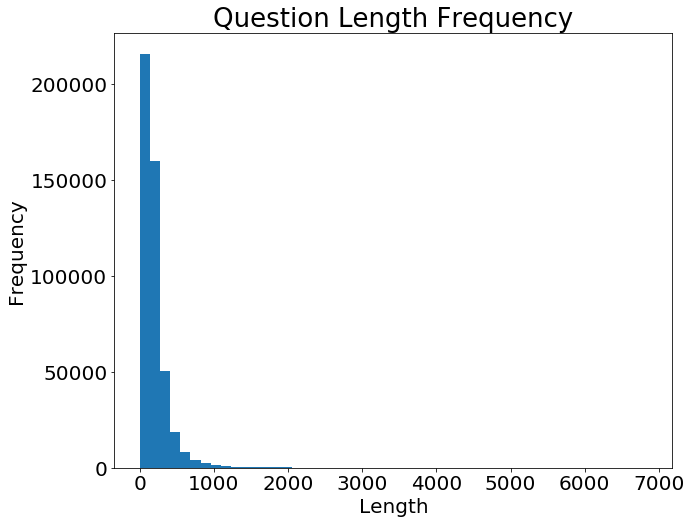

In [18]:
# Histogram of Question Length Frequency 

plt.figure(figsize=(10,8))

plt.hist(x = df['body_length'], bins = 50)

plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);

plt.title('Question Length Frequency', fontsize = 26)
plt.xlabel('Length', fontsize=20)
plt.ylabel('Frequency', fontsize=20);

## Most Frequent Words 
    - For whole corpus 
    - Language Specific 
        - SQL
        - Scala 
        - R
        - Julia
        - C++
        - Python

### Most Frequent Words (ALL) 

###  Functions: 

#### freq_words

In [43]:
def freq_words(df):
    '''
    Function that takes in dataframe:
        - splits into X, y 
        - creates CountVectorizer instance 
        - takes sparse matrix --> dataframe (sum of total times certain word used)
        - returns the above dataframe 
    Returns: Dataframe, with word: frequency 
    
    '''
    X = df['body_clean']
    y = df['target_class']
    
    cvec = CountVectorizer(stop_words='english', 
                           max_features = 250,   
                           ngram_range = (1,1)) 

    # Sparse Matrix
    sparse_cv = cvec.fit_transform(X)

    # Sparse matrix --> Dataframe
    cvec_df = pd.DataFrame(sparse_cv.toarray(), columns=cvec.get_feature_names())

    # Total times word was used 
    sum_words = cvec_df.sum(axis=0) 
    
    # Dataframe 
    top_words = pd.DataFrame(sum_words.sort_values(ascending = False), columns = ['count'])
    
    # Reset index
    top_words = top_words.reset_index()
    
    # Change Column name from index --> word 
    top_words = top_words.rename(columns={'index': 'word'})
    
    return top_words

#### bar_graph_words
- Colors for bars: 
    - 'xkcd:lavender'
        - https://xkcd.com/color/rgb/


In [122]:
def bar_graph_words(top15, language = 'test', number = 1, bar_color = 'blue'):
    '''
    input: 
    
    output: bar graph: top 15 words (total/language specific)
    
    '''
    # Wanted to have most frequent words on top 
    top15.sort_values('count', ascending = True).set_index('word', inplace = False).plot(kind = 'barh', figsize = (20, 15), color = bar_color);
                                                                                         
    plt.title((f'Top 15 Words: {language}'), fontsize=50, pad = 25)
    
    plt.xlabel('Frequency', fontsize= 39, labelpad=35)
    plt.ylabel('Word', fontsize = 39, labelpad=35)
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    
    plt.savefig((f'../images/bargraph_{language}_{number}.png'),bbox_inches='tight')
    
    return plt.show();

#### word_cloud

In [85]:
def word_cloud(freq_df, cloud_name = 'test', number = 1):
    '''
    inputs: 
    freq_df = 
    cloud_name (string) = 
    number (int) = change this number so you don't overwrite existing word clouds  
    
    
    outputs:
    
    '''
    # empty dictionary 
    d = {}

    # freq_df is a pandas DataFrame with columns words and counts
    # created using freq_words function 
    for a, x in freq_df.values:
        d[a] = x

    # instantiate wordcloud 
    wordcloud = WordCloud(max_words=250,
                          max_font_size= 600,
                          background_color="white", 
                          width=1600, height=800)         # increases resolution of image 
    
    # generate word cloud based on frequencies 
    wordcloud.generate_from_frequencies(frequencies=d)

    # figure information/dimensions
    plt.figure(figsize=(20,15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.savefig((f'../images/wordcloud_{cloud_name}{number}.png'),bbox_inches='tight')
    
    return plt.show();

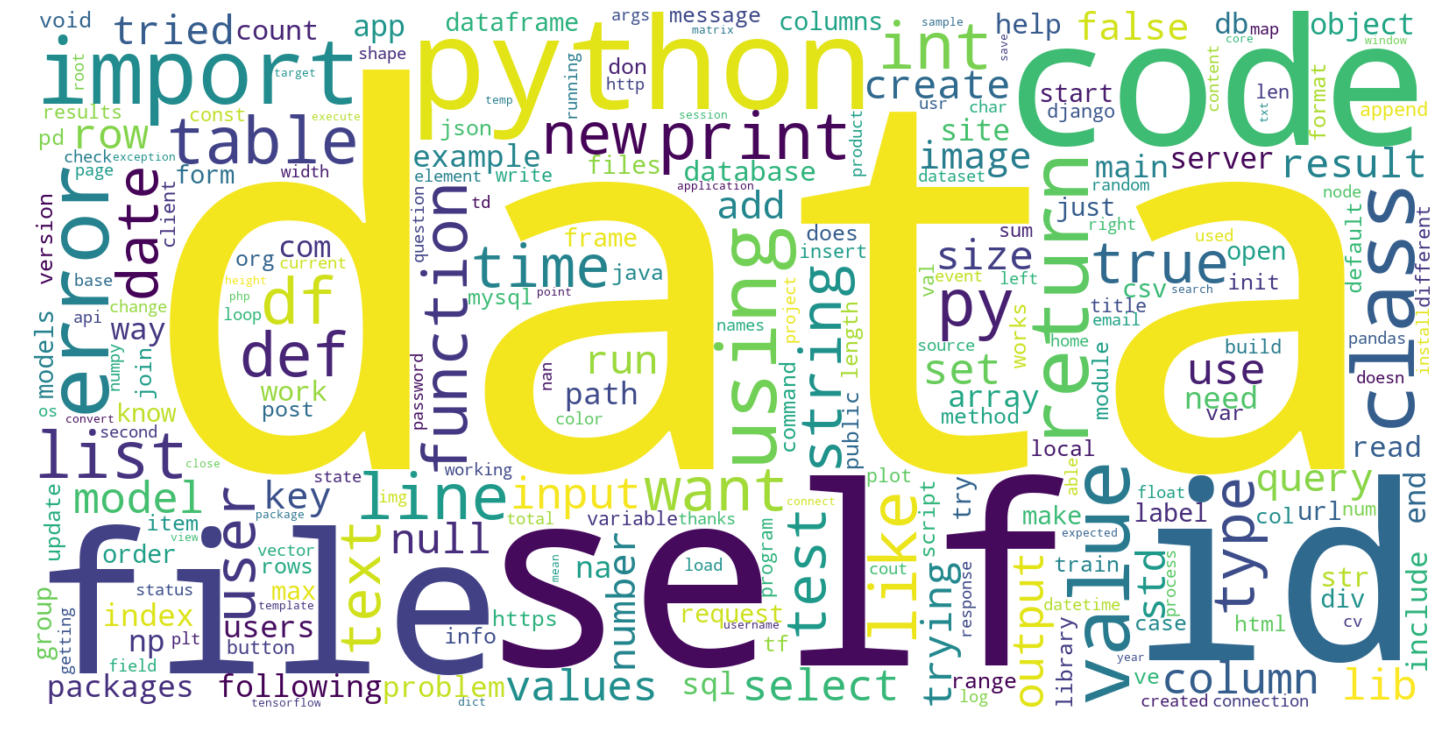

In [142]:
word_cloud(total_frequency, 'test', 10)

### Top Words

In [77]:
total_frequency = freq_words(df)

In [94]:
total_frequency.head()

,word,count
0,data,547115
1,self,469186
2,id,449011
3,file,406416
4,code,335646


In [45]:
total_top15 = total_frequency[0:15]

#### Bargraph

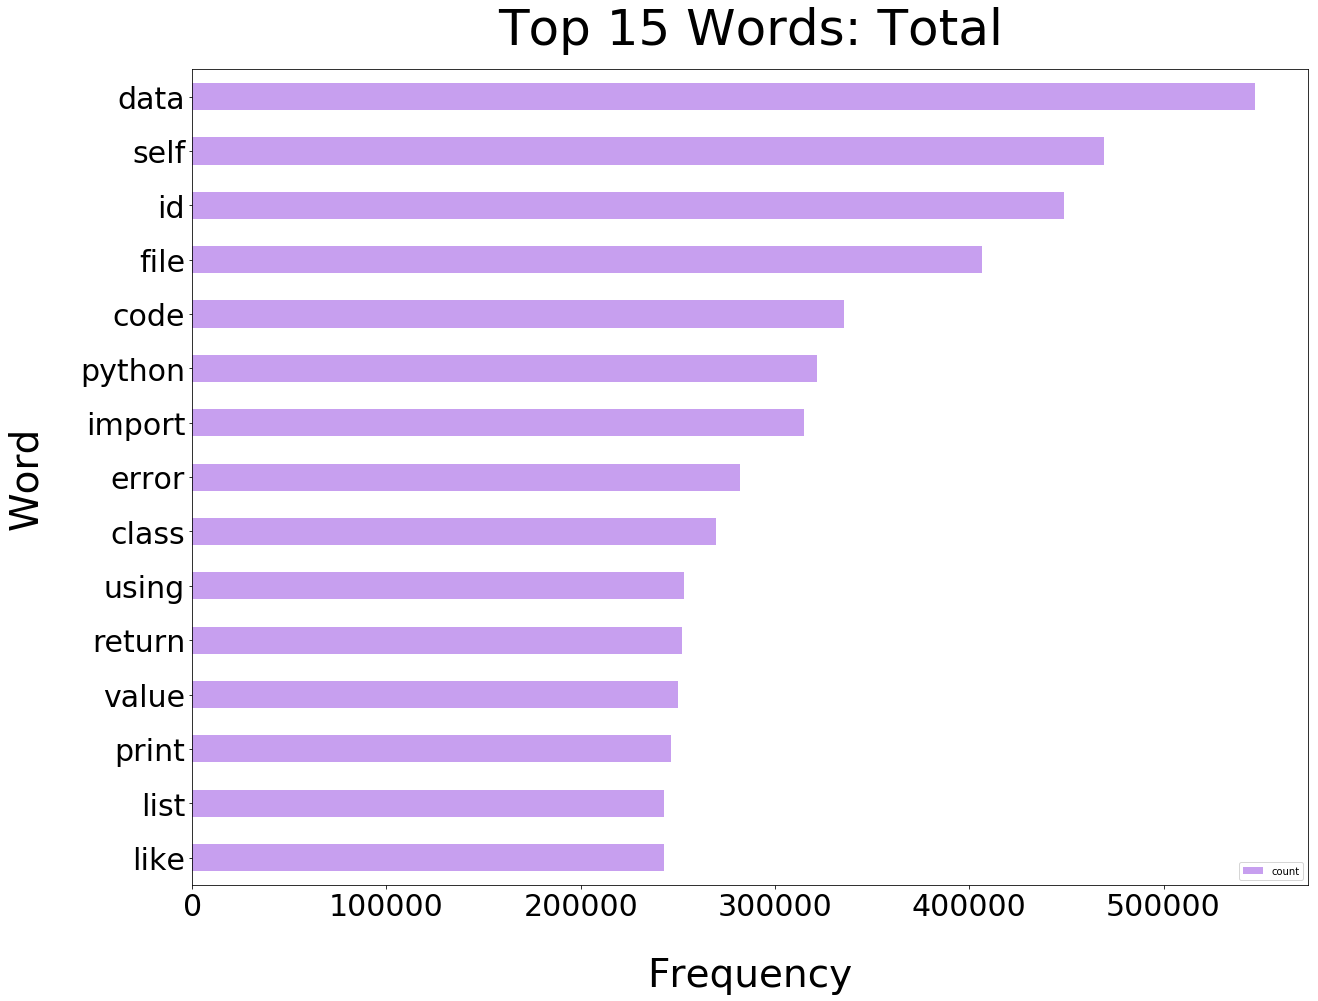

In [141]:
bar_graph_words(total_top15, language = 'Total', number = 1, bar_color = 'xkcd:lavender')

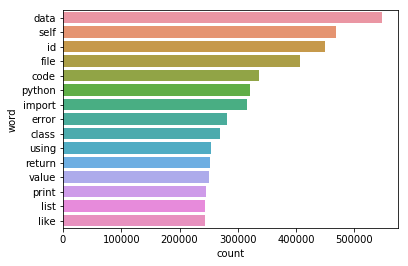

In [135]:
# https://seaborn.pydata.org/generated/seaborn.barplot.html 
sns.barplot(data=total_top15, 
            x = 'count', 
            y = 'word');
            #dodge=False)

#### WordCloud

### SQL

In [37]:
sql_df = df[df['target_class'] == 0]

In [38]:
# use for word cloud -- rerun 
sql_frequency = freq_words(sql_df)

In [39]:
# use for bar graph
sql_top15 = sql_frequency[0:15]

### Most Frequent Words: Scala

In [50]:
scala_df = df[df['target_class'] == 1]

In [51]:
scala_frequency = freq_words(scala_df)

In [52]:
scala_top15 = scala_frequency[0:15]

### Most Frequent Words: R

In [53]:
r_df = df[df['target_class'] == 2]

In [54]:
r_frequency = freq_words(r_df)

In [55]:
r_top15 = r_frequency[0:15]

### Most Frequent Words: Julia

In [56]:
julia_df = df[df['target_class'] == 3]

In [57]:
julia_frequency = freq_words(julia_df)

In [58]:
julia_top15 = julia_frequency[0:15]

### Most Frequent Words: C++

In [59]:
cplus_df = df[df['target_class'] == 4]

In [60]:
cplus_frequency = freq_words(cplus_df)

In [61]:
cplus_top15 = cplus_frequency[0:15]

### Most Frequent Words: Python

In [62]:
python_df = df[df['target_class'] == 5]

In [63]:
python_frequency = freq_words(python_df)

In [64]:
python_top15 = python_frequency[0:15]

#### Bargraph

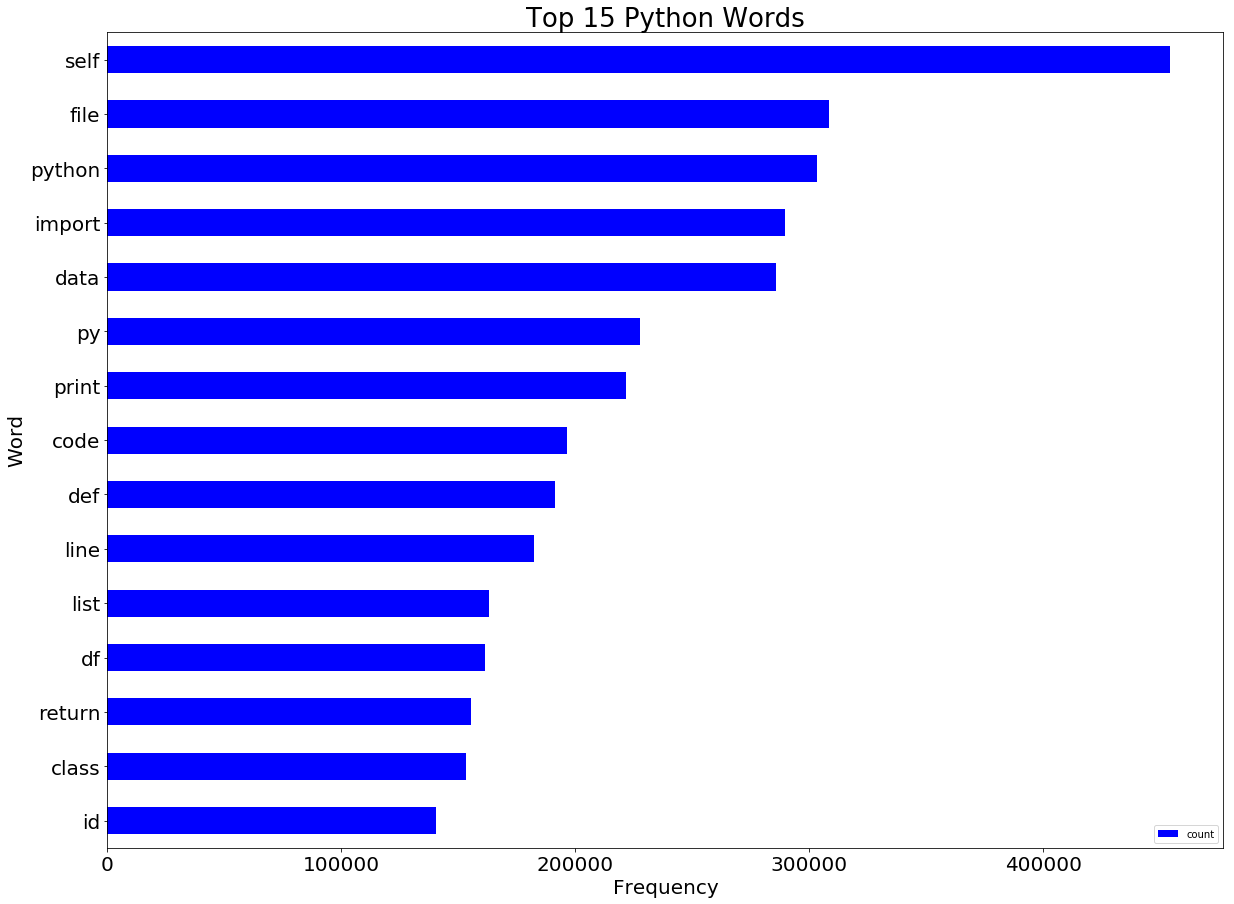

In [334]:
python_frequency[0:15].sort_values('count', ascending = True).set_index('word', inplace = False).plot(kind = 'barh', figsize = (20, 15), color = 'blue');

plt.title('Top 15 Python Words', fontsize=26)
plt.xlabel('Frequency', fontsize=20);
plt.ylabel('Word', fontsize = 20);
plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);

## Most Frequent Bi-words

### Function 
#### Bi-gram Freqency 

In [46]:
def freq_biwords(df):
    '''
    function that takes in dataframe:
        - splits into X, y 
        - creates CountVectorizer instance (bigrams)
        - takes sparse matrix --> dataframe (sum of total times certain word used)
        - returns the above dataframe 
    Returns: Dataframe, with word: frequency 
    
    '''
    X = df['body_clean']
    y = df['target_class']
    
    cvec_bi = CountVectorizer(stop_words='english', 
                           max_features = 250,   
                           ngram_range = (2,2))    # bi-gram

    # Sparse Matrix
    sparse_bi_cv = cvec_bi.fit_transform(X)

    # Sparse matrix --> Dataframe
    cvec_bi_df = pd.DataFrame(sparse_bi_cv.toarray(), columns=cvec_bi.get_feature_names())

    # Total times word was used 
    sum_bi_words = cvec_bi_df.sum(axis=0) 
    
    # Dataframe 
    top_biwords = pd.DataFrame(sum_bi_words.sort_values(ascending = False), columns = ['count'])
    
    # Reset index
    top_biwords = top_biwords.reset_index()
    
    # Change Column name from index --> word 
    top_biwords = top_biwords.rename(columns={'index': 'word'})
    
    return top_biwords

### Top Bi-Grams

In [48]:
total_bifreq = freq_biwords(df)
total_bifreq.head()

,word,count
0,py line,103146
1,site packages,77886
2,na na,63087
3,lib python,58404
4,data frame,41324


#### Bargraph

#### WordCloud 

### SQL

In [47]:
sql_bifreq = freq_biwords(sql_df)
sql_bifreq.head()

,word,count
0,sql server,18426
1,null null,14311
2,create table,13949
3,inner join,13842
4,user id,13672


In [76]:
sql_top15bi = sql_bifreq[0:15]

#### Bargraph

#### WordCloud 

### Scala

In [65]:
scala_bifreq = freq_biwords(scala_df)
scala_bifreq.head()

,word,count
0,org apache,11722
1,apache spark,9109
2,scala org,5920
3,spark sql,4894
4,case class,2450


In [75]:
sc_top15bi = scala_bifreq[0:15]

#### Bargraph

#### WordCloud 

### R

In [66]:
r_bifreq = freq_biwords(r_df)
r_bifreq.head()

,word,count
0,na na,61900
1,data frame,33254
2,data table,6126
3,data data,5985
4,df data,5938


In [74]:
r_top15bi = r_bifreq[0:15]

#### Bargraph

#### WordCloud 

### Julia

In [67]:
julia_bifreq = freq_biwords(julia_df)
julia_bifreq.head()

,word,count
0,end end,329
1,array float,299
2,julia packages,290
3,jl inlined,286
4,share julia,226


In [73]:
j_top15bi = julia_bifreq[0:15]

#### Bargraph

#### WordCloud 

### C++

In [68]:
cplus_bifreq = freq_biwords(cplus_df)
cplus_bifreq.head()

,word,count
0,std cout,17148
1,int main,16549
2,std string,14177
3,int int,12757
4,std vector,10987


In [72]:
cplus_top15bi = cplus_bifreq[0:15]

#### Bargraph

#### WordCloud 

### Python

In [69]:
python_bifreq = freq_biwords(python_df)
python_bifreq.head()

,word,count
0,py line,98677
1,site packages,74246
2,lib python,55690
3,python site,39007
4,lib site,34236


In [71]:
py_top15bi = python_bifreq[0:15]

#### Bargraph

#### WordCloud 